In [ ]:
!pip install yfinance
!pip install scikit-learn


In [ ]:
import yfinance as yf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd


Linear Regression: MSE = 13.65, R² = 0.87
SVR: MSE = 16.31, R² = 0.85


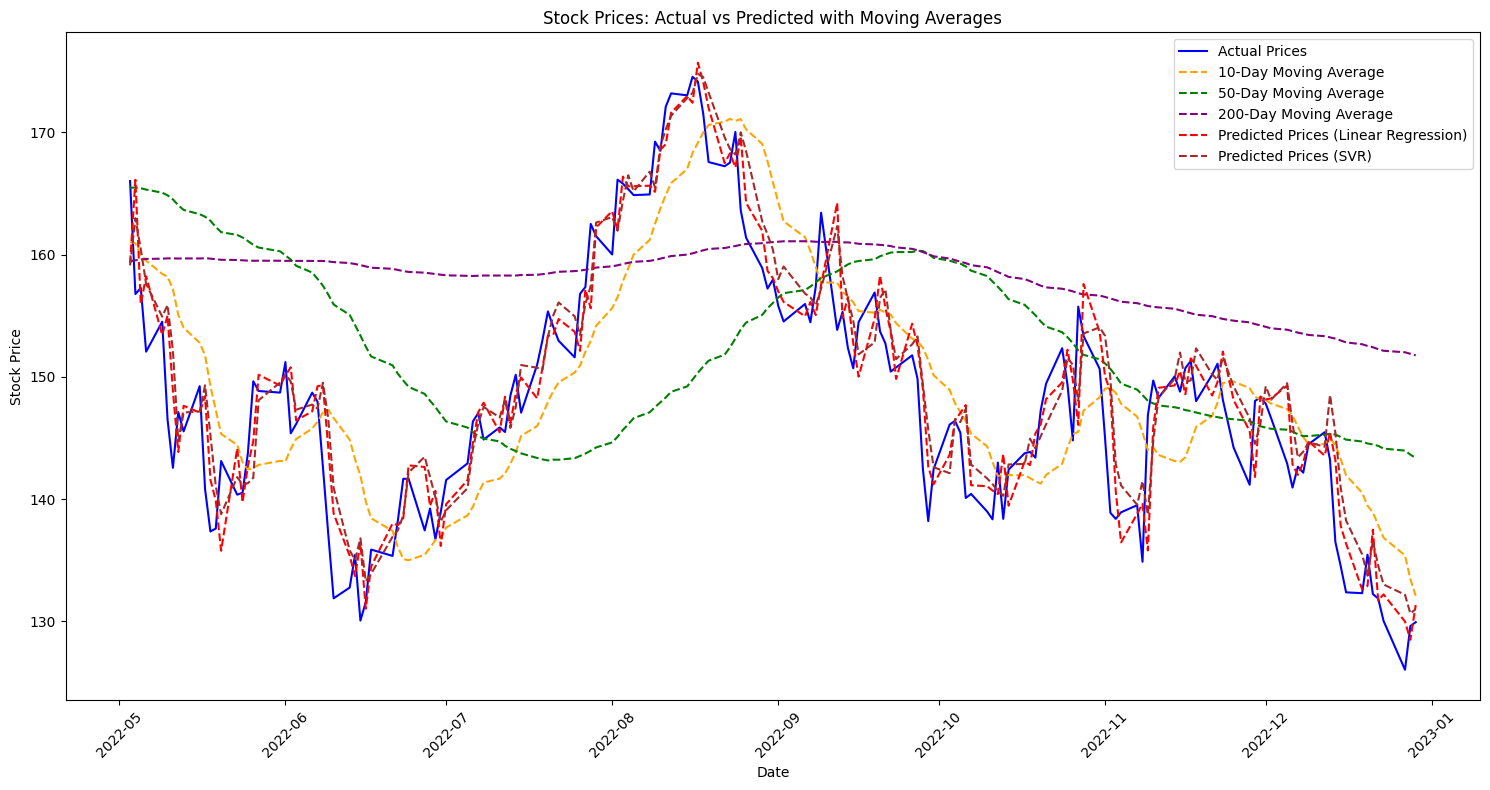

In [ ]:
# Download historical stock data (e.g., Apple stock 'AAPL') from yfinance
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", end="2023-01-01", progress=False)

# Ensure that the Date column is the index and properly formatted
data.index = pd.to_datetime(data.index)

# Feature Engineering: Add moving averages (MA) as additional features
data['MA_10'] = data['Close'].rolling(window=10).mean()  # 10-day moving average
data['MA_50'] = data['Close'].rolling(window=50).mean()  # 50-day moving average
data['MA_200'] = data['Close'].rolling(window=200).mean()  # 200-day moving average

# Create the target variable: predicting the next day's 'Close' price
data['Target'] = data['Close'].shift(-1)  # Shift the 'Close' column to create the target for the next day

# Drop rows with NaN values that resulted from moving averages and shifting
data.dropna(inplace=True)

# Define features (X) and target (y)
X = data[['Open', 'High', 'Low', 'Volume', 'MA_10', 'MA_50', 'MA_200']]
y = data['Target']

# Split into training and testing data (train on past data, test on future unseen data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Pipeline 1: Using Linear Regression
pipeline_lr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),   # Handle missing values
    ('scaler', StandardScaler()),                 # Scale features
    ('regressor', LinearRegression())             # Linear Regression model
])

# Pipeline 2: Using Support Vector Regressor (SVR)
pipeline_svr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),   # Handle missing values
    ('scaler', StandardScaler()),                 # Scale features
    ('regressor', SVR(kernel='linear'))           # Support Vector Regressor model
])

# Fit both pipelines on the training data
pipeline_lr.fit(X_train, y_train)
pipeline_svr.fit(X_train, y_train)

# Now we can use both pipelines to predict on the test data
y_pred_lr = pipeline_lr.predict(X_test)  # Predictions from Linear Regression
y_pred_svr = pipeline_svr.predict(X_test)  # Predictions from SVR

# Evaluation Metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

# Print the evaluation metrics
print(f"Linear Regression: MSE = {mse_lr:.2f}, R² = {r2_lr:.2f}")
print(f"SVR: MSE = {mse_svr:.2f}, R² = {r2_svr:.2f}")

# Plot the actual vs predicted stock prices for both models and moving averages
dates = X_test.index  # Use the index of the test data (which corresponds to the dates)

plt.figure(figsize=(15, 8))

# Plot the Actual Prices and Moving Averages
plt.plot(dates, y_test.values, label="Actual Prices", color="blue")
plt.plot(dates, data.loc[dates]['MA_10'], label="10-Day Moving Average", color="orange", linestyle="--")
plt.plot(dates, data.loc[dates]['MA_50'], label="50-Day Moving Average", color="green", linestyle="--")
plt.plot(dates, data.loc[dates]['MA_200'], label="200-Day Moving Average", color="purple", linestyle="--")

# Plot Linear Regression Predictions
plt.plot(dates, y_pred_lr, label="Predicted Prices (Linear Regression)", color="red", linestyle="--")

# Plot SVR Predictions
plt.plot(dates, y_pred_svr, label="Predicted Prices (SVR)", color="brown", linestyle="--")

# Add titles and labels
plt.title("Stock Prices: Actual vs Predicted with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)  # Rotate the dates for better visibility
plt.legend()

plt.tight_layout()
plt.show()
